In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## Učitavanje podataka i imenovanje kolona
U datasetu ne postoje labele za kolone, pa je potrebno ručno uneti. Pored kolona za pobedu, region, mod i tip igre, postoji još 113 kolona, koje predstavljaju po jednog dota2 heroja, i one su numerisane 0-112.

In [2]:
col_names = ['win', 'region', 'mode', 'type']
num_arr_str = np.arange(113).astype(str)
all_names = np.concatenate((col_names, num_arr_str), axis = 0)

dota_data = pd.read_csv("dota2.csv", header=None, names=all_names)

In [3]:
dota_data.head(5)

,win,region,mode,type,0,1,2,3,4,5,...,103,104,105,106,107,108,109,110,111,112
0,-1,223,8,2,0,-1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
1,1,227,8,2,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
2,-1,136,2,2,1,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,227,2,2,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,184,2,3,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Predstavljanje podataka pomoću grafikona

Naredni grafikon pokazuje zastupljenost regiona u mečevima

{227: 8781, 154: 7751, 156: 7668, 151: 7612, 153: 7513, 152: 7460, 155: 7325, 224: 6625, 231: 4040, 223: 3892, 225: 2947, 232: 1880, 204: 1646, 182: 1519, 187: 1408, 145: 1374, 144: 1348, 188: 1335, 181: 1315, 171: 1224, 186: 1204, 184: 1096, 185: 1080, 183: 1045, 191: 1038, 111: 918, 192: 913, 112: 901, 132: 845, 133: 843, 131: 820, 121: 788, 138: 775, 123: 748, 134: 737, 122: 736, 124: 723, 135: 688, 136: 688, 137: 687, 261: 300, 161: 271, 251: 168, 241: 142, 213: 97, 211: 19, 212: 11}


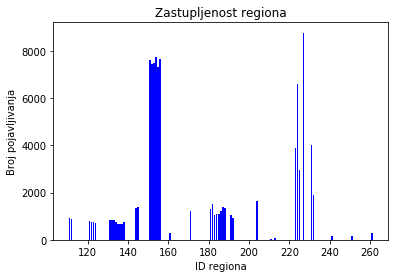

In [4]:
regi = dota_data.iloc[:,1]
abc = dict(regi.value_counts())

x = np.fromiter(abc.keys(), dtype=int)
y = np.fromiter(abc.values(), dtype=int)

fig, ax = plt.subplots()

ax.bar(x, y, align='center', color='b')

ax.set_title('Zastupljenost regiona')
ax.set_ylabel('Broj pojavljivanja')
ax.set_xlabel('ID regiona')
print(abc)

plt.show()

Naredni grafikon pokazuje zastupljenost tipa igre u mečevima

1: Practice 2: Tournament 3: Tutorial
{2: 63272, 3: 39652, 1: 20}


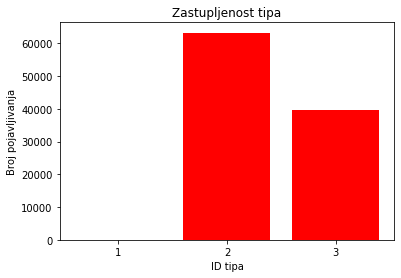

In [5]:
type_match = dota_data.iloc[:,3]
abc = dict(type_match.value_counts())

x = np.fromiter(abc.keys(), dtype=int)
y = np.fromiter(abc.values(), dtype=int)

fig, ax = plt.subplots()

ax.bar(x, y, align='center', color='r')

ax.set_title('Zastupljenost tipa')
ax.set_ylabel('Broj pojavljivanja')
ax.set_xlabel('ID tipa')

ax.set_xticks(x)
ax.set_xticklabels(x)

print("1: Practice", "2: Tournament", "3: Tutorial")
print(abc)

plt.show()

## Provera tipova podataka i postojanje null vrednosti
Iz naredne linije možemo videti da je dataset većih dimenzija, pa je to uzeto u obzir prilikom treniranja.

In [6]:
dota_data.shape

(102944, 117)

In [7]:
#Brisanje duplikata
dota_data = dota_data.drop_duplicates()

Izvršene su provere za NULL podatke i da li su svi podaci brojevne vrednosti.

In [8]:
#Broj null podataka u svakoj koloni
dota_data.isnull().sum()

win       0
region    0
mode      0
type      0
0         0
         ..
108       0
109       0
110       0
111       0
112       0
Length: 117, dtype: int64

In [9]:
#provera tipova podataka
dota_data.dtypes

win       int64
region    int64
mode      int64
type      int64
0         int64
          ...  
108       int64
109       int64
110       int64
111       int64
112       int64
Length: 117, dtype: object

## Preprocesiranje podataka
Bilo je potrebno grupisani podatke u odnosu na region, kako bi se dalo na značaju.
Takođe, izbačeni su i tipovi i modovi igre koji se odnose na Tutorial, jer nemaju značaj i predstavljaju trivijalne mečeve.

In [10]:
#Grupisanje regiona
dota_data.loc[dota_data["region"].isin([111,112,113,114]), "region"] = 1 #US West
dota_data.loc[dota_data["region"].isin([121,122,123,124]), "region"] = 2 #US East
dota_data.loc[dota_data["region"].isin([131,132,133,134,135,136,137,138]), "region"] = 3 #Europe West
dota_data.loc[dota_data["region"].isin([142,143,144,145]), "region"] = 4 #South Korea
dota_data.loc[dota_data["region"].isin([151,152,153,154,155,156]), "region"] = 5 #Southeast Asia
dota_data.loc[dota_data["region"].isin([161,163, 221,222,223,224,225,227,231,232]), "region"] = 6 #China
dota_data.loc[dota_data["region"].isin([171]), "region"] = 7 #Australia
dota_data.loc[dota_data["region"].isin([181,182,183,184, 185,186,187,188]), "region"] = 8 #Russia
dota_data.loc[dota_data["region"].isin([191,192]), "region"] = 9 #Europe East
dota_data.loc[dota_data["region"].isin([200,202,203,204]), "region"] = 10 #South America
dota_data.loc[dota_data["region"].isin([211,212,213]), "region"] = 11 #South Africa
dota_data.loc[dota_data["region"].isin([241,242]), "region"] = 12 #Chile
dota_data.loc[dota_data["region"].isin([251]), "region"] = 13 #Peru
dota_data.loc[dota_data["region"].isin([261]), "region"] = 14 #India
dota_data['region'].head(5)

0    6
1    6
2    3
3    6
4    8
Name: region, dtype: int64

In [11]:
#Uklanjanje instanci ciji je tip igre 'Tutorial' ili 'Practice'
df_f1 = dota_data[(dota_data['type'] != 3) & (dota_data['type'] != 1)]

#Uklanjanje instanci ciji je mod igre 'Tutorial' 
df_f2 = df_f1[df_f1['mode'] != 10]

In [12]:
df_f2['win'].value_counts()

 1    33388
-1    29884
Name: win, dtype: int64

Balansiranje pobeda tima 1 i tima 2 za bolje rezultate.

In [13]:
#balansiranje dataseta
g = df_f2.groupby('win')
g = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
g['win'].value_counts()

 1    29884
-1    29884
Name: win, dtype: int64

## Predstavljanje preprocesiranih podataka pomoću grafikona

Naredni grafikoni pokazuju učestalost korišćenja heroja u zasebnim mečevima

DescribeResult(nobs=113, minmax=(0, 20619), mean=5289.203539823009, variance=16054406.002844501, skewness=1.5718836882093972, kurtosis=2.4386477026441096)


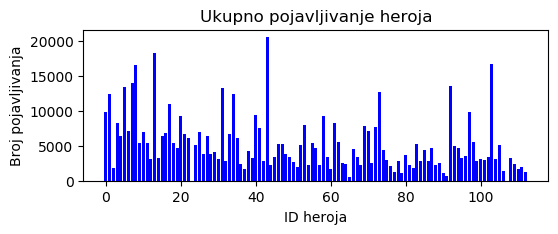

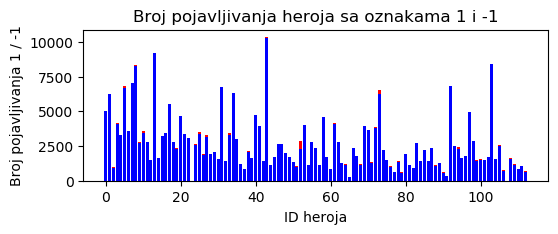

In [14]:
heroes = g.iloc[:,4:]
len_matches = len(heroes);
num_arr = np.arange(113)

heroes_counts=[]
pos=[]
neg=[]

for x in num_arr_str:
    hero = dict(heroes[x].value_counts())
    if hero[0]!=len_matches:
        pos.append(hero[1])
        neg.append(hero[-1])
    else:
        pos.append(0)
        neg.append(0)
    heroes_counts.append(hero)
        
sum = np.add(pos, neg)

print(stats.describe(sum)) 

plt.rcParams['figure.figsize'] = [6, 2]
plt.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots()

ax.bar(num_arr, sum, align='center', color='b')
ax.set_title('Ukupno pojavljivanje heroja')
ax.set_ylabel('Broj pojavljivanja')
ax.set_xlabel('ID heroja')
plt.show()

#prvi zajednicki
fig1, ax1 = plt.subplots()
ax1.bar(num_arr, pos, align='center', color='r')
ax1.bar(num_arr, neg, align='center', color='b')
ax1.set_title('Broj pojavljivanja heroja sa oznakama 1 i -1')
ax1.set_ylabel('Broj pojavljivanja 1 / -1')
ax1.set_xlabel('ID heroja')

plt.show()
plt.show()

Naredni grafikon pokazuje zastupljenost regiona u mečevima

1: US West 2: US East 3: Europe West 4: South Korea 5: Southeast Asia 6: China 7: Australia 8: Russia 9: Europe East 10: South America 11: South Africa 12: Chile 13: Peru 14: India
{5: 26696, 6: 15937, 8: 6489, 3: 3173, 4: 1650, 2: 1478, 1: 1073, 9: 1056, 10: 905, 7: 722, 14: 220, 12: 126, 13: 123, 11: 120}


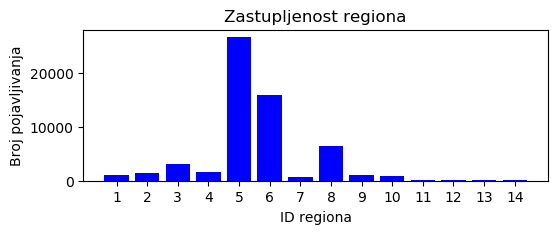

In [15]:
regi = g.iloc[:,1]
abc = dict(regi.value_counts())

x = np.fromiter(abc.keys(), dtype=int)
y = np.fromiter(abc.values(), dtype=int)

fig, ax = plt.subplots()
ax.bar(x, y, align='center', color='b')

ax.set_title('Zastupljenost regiona')
ax.set_ylabel('Broj pojavljivanja')
ax.set_xlabel('ID regiona')

print("1: US West", "2: US East", "3: Europe West", "4: South Korea", "5: Southeast Asia", "6: China", "7: Australia", "8: Russia", "9: Europe East", "10: South America","11: South Africa","12: Chile","13: Peru","14: India")
print(abc)

ax.set_xticks(x)
ax.set_xticklabels(x)
plt.show()

Naredni grafikon pokazuje zastupljenost moda igre u mečevima

1: All Pick 2: Captains Mode 3: Random Draft 4: Single Draft 5: All Random 6: INTRO/DEATH 7: The Diretide 8: Reverse Captains Mode 9: Greevilin
{2: 43219, 9: 10562, 8: 3689, 1: 1284, 3: 416, 6: 286, 4: 207, 7: 93, 5: 12}


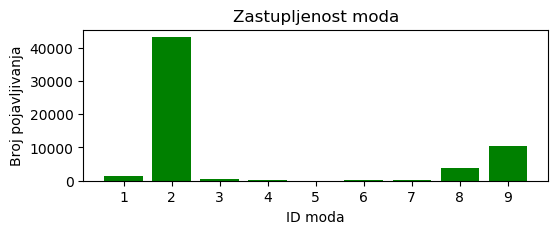

In [16]:
mode = g.iloc[:,2]
abc = dict(mode.value_counts())

x = np.fromiter(abc.keys(), dtype=int)
y = np.fromiter(abc.values(), dtype=int)

fig, ax = plt.subplots()
ax.bar(x, y, align='center', color='g')

ax.set_title('Zastupljenost moda')
ax.set_ylabel('Broj pojavljivanja')
ax.set_xlabel('ID moda')

ax.set_xticks(x)
ax.set_xticklabels(x)

print("1: All Pick", "2: Captains Mode", "3: Random Draft", "4: Single Draft", "5: All Random", "6: INTRO/DEATH", "7: The Diretide", "8: Reverse Captains Mode", "9: Greevilin")
print(abc)

plt.show()

Naredni grafikon pokazuje zastupljenost tipa igre u mečevima

2: Tournament
{2: 59768}


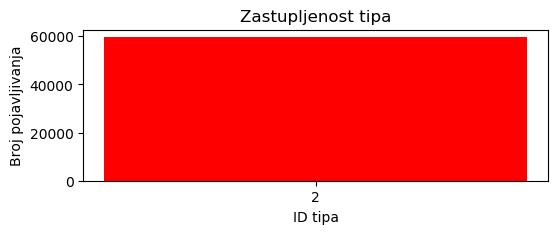

In [17]:
type_match = g.iloc[:,3]
abc = dict(type_match.value_counts())

x = np.fromiter(abc.keys(), dtype=int)
y = np.fromiter(abc.values(), dtype=int)

fig, ax = plt.subplots()

ax.bar(x, y, align='center', color='r')

ax.set_title('Zastupljenost tipa')
ax.set_ylabel('Broj pojavljivanja')
ax.set_xlabel('ID tipa')

ax.set_xticks(x)
ax.set_xticklabels(x)

print("2: Tournament")
print(abc)

plt.show()

# Razdvajanje feature i target kolona

In [18]:
Y = g.iloc[:,0]
X = g.iloc[:,1:]

## Razdvajanje train i test setova 80:20

In [19]:
from sklearn.model_selection import train_test_split
#random state = 1, kako bi se koristio int seed za RNG
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [20]:
def draw_conf_matrix(confusion_mat):
    plt.rcParams['figure.figsize'] = [3, 2.5]
    plt.rcParams['figure.dpi'] = 100
    df_conf = pd.DataFrame(confusion_mat, index=['1', '-1'], columns=['1', '-1'])
    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    res = sns.heatmap(df_conf, annot=True, vmin=2346.0/2, vmax=3670.0, fmt='.2f', cmap=cmap)
    res.invert_yaxis()
    res.invert_xaxis()
    plt.title('Matrica konfuzije')
    plt.show()

## Treniranje modela korišćenjem Linear Support Vector klasifikacije

LinearSVC accuracy :  0.5957001840388154
Confusion matrix:
[[3548 2390]
 [2443 3573]]


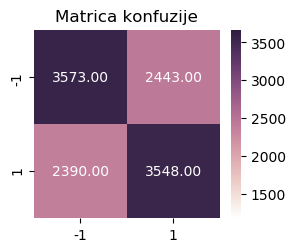

Report:
              precision    recall  f1-score   support

          -1       0.59      0.60      0.59      5938
           1       0.60      0.59      0.60      6016

    accuracy                           0.60     11954
   macro avg       0.60      0.60      0.60     11954
weighted avg       0.60      0.60      0.60     11954



In [25]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
svc_model = LinearSVC(random_state=0,max_iter = 100000, dual = False, penalty='l2')

pred = svc_model.fit(X_train, Y_train).predict(X_test)
print("LinearSVC accuracy : ",accuracy_score(Y_test, pred, normalize = True))
print("Confusion matrix:")
confusion_mat=confusion_matrix(Y_test, pred)
print(confusion_mat)

draw_conf_matrix(confusion_mat)

print("Report:")
print(classification_report(Y_test, pred))

## Treniranje modela korišćenjem logističke regresije

Accuracy of Logistic regression classifier on training set:  0.6002844355209771
Accuracy of Logistic regression classifier on test set:  0.5959511460598963 

Confusion matrix:
[[3555 2383]
 [2447 3569]]


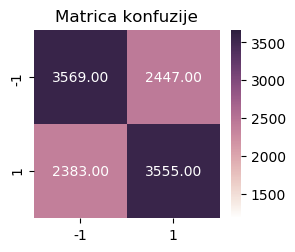

Report:
              precision    recall  f1-score   support

          -1       0.59      0.60      0.60      5938
           1       0.60      0.59      0.60      6016

    accuracy                           0.60     11954
   macro avg       0.60      0.60      0.60     11954
weighted avg       0.60      0.60      0.60     11954



In [22]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000, dual=False)
logreg.fit(X_train,Y_train)
pred = logreg.predict(X_test)

print('Accuracy of Logistic regression classifier on training set: ',logreg.score(X_train, Y_train))
print('Accuracy of Logistic regression classifier on test set: ', accuracy_score(Y_test, pred),'\n')
print("Confusion matrix:")
confusion_mat=confusion_matrix(Y_test, pred)
print(confusion_mat)
draw_conf_matrix(confusion_mat)
print("Report:")
print(classification_report(Y_test, pred))

## Treniranje modela korišćenjem Random Forest klasifikatora

Accuracy of Random forest classifier on test set:  0.5854107411745023
Confusion matrix:
[[3512 2426]
 [2530 3486]]


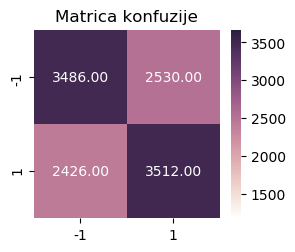

Report:
              precision    recall  f1-score   support

          -1       0.58      0.59      0.59      5938
           1       0.59      0.58      0.58      6016

    accuracy                           0.59     11954
   macro avg       0.59      0.59      0.59     11954
weighted avg       0.59      0.59      0.59     11954



In [23]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0, n_estimators=200, criterion='entropy', min_samples_split=2
                            ,n_jobs=-1,bootstrap=True,min_samples_leaf=20)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
print('Accuracy of Random forest classifier on test set: ',accuracy_score(Y_test, pred))
print("Confusion matrix:")
confusion_mat=confusion_matrix(Y_test, pred)
print(confusion_mat)

draw_conf_matrix(confusion_mat)
print("Report:")
print(classification_report(Y_test, pred))

## Treniranje modela korišćenjem SGD (stochastic gradient descent) klasifikatora

Accuracy of SGD classifier on test set:  0.5959511460598963
Confusion matrix:
[[3551 2387]
 [2443 3573]]


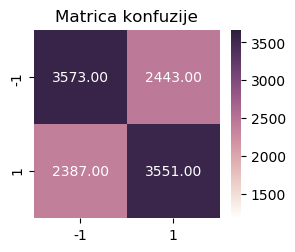

Report:
              precision    recall  f1-score   support

          -1       0.59      0.60      0.60      5938
           1       0.60      0.59      0.60      6016

    accuracy                           0.60     11954
   macro avg       0.60      0.60      0.60     11954
weighted avg       0.60      0.60      0.60     11954



In [24]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', penalty='l1',fit_intercept=False, learning_rate='adaptive',eta0=1
                   ,power_t=0.5, max_iter=1000)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)
print('Accuracy of SGD classifier on test set: ',accuracy_score(Y_test, pred))
print("Confusion matrix:")
confusion_mat=confusion_matrix(Y_test, pred)
print(confusion_mat)

draw_conf_matrix(confusion_mat)
print("Report:")
print(classification_report(Y_test, pred))

# Zaključak:
Dati dataset ni u jednom slučaju klasifikacije nema rezultate koji se mogu smatrati odličnim. Ovo možemo pripisati tome da ishod pobede u meču zavisi u najvećem slučaju od ljudskog faktora, od "skill-a" igrača, koji ne možemo izmeriti. Svi primenjeni algoritmi imaju preciznost veću od 50%, pa možemo smatrati da je donekle klasifikacija bila uspešna, iako daleko od idealne.